In [2]:
import numpy as np
import matplotlib.pyplot as plt
from SED_v8 import AGN
from SED_plots_v2 import Plotter
from astropy.io import fits
from astropy.io import ascii
from match import match
from scipy import interpolate
from scipy import integrate

In [3]:
# Path for photometry catalogs
path = '/Users/connor_auge/Research/Disertation/catalogs/'

# set redshift and X-ray luminosity limits
z_min = 0.0
z_max = 1.2

Lx_min = 43
Lx_max = 60

# set the X-ray luminosity limits for the GOALS sources
goals_Lx_min = 35


In [4]:
# COSMOS2020 catalog
cosmos = fits.open(path+'COSMOS2020_CLASSIC_R1_v2.2_p3.fits')
cosmos_data = cosmos[1].data
cosmos.close()

# COSMOS2015 catalog
cosmos2015 = fits.open(path+'COSMOS2015_Laigle+_v1.1.fits')
cosmos2015_data = cosmos2015[1].data
cosmos2015.close()

# COSMOS FIR catalog 
cosmos_fir = fits.open(path+'cosmos_superdeblended.fit')
cosmos_fir_data = cosmos_fir[1].data
cosmos.close()

# Chandra 2016 catalog
chandra_cosmos = fits.open(path+'chandra_COSMOS_legacy_opt_NIR_counterparts_20160113_4d.fits')
chandra_cosmos_data = chandra_cosmos[1].data
chandra_cosmos.close()

# Chandra updated fits catalog
chandra_cosmos2 = fits.open(path+'chandra_cosmos_legacy_spectra_bestfit_20210225.fits')
chandra_cosmos2_data = chandra_cosmos2[1].data
chandra_cosmos2.close()

# Chandra compton thick catalog
chandra_cosmos_ct = fits.open(path+'chandra_cosmos_legacy_spectra_bestfit_ComptonThick_Lanzuisi18.fits')
chandra_cosmos_ct_data = chandra_cosmos_ct[1].data
chandra_cosmos_ct.close()

# DEIMOS 10k Spec z cat
deimos = ascii.read('/Users/connor_auge/Downloads/deimos_10k_March2018_new/deimos_redshifts.tbl')
deimos_id = np.asarray(deimos['ID'])
deimos_z = np.asarray(deimos['zspec'])
deimos_remarks = np.asarray(deimos['Remarks'])
deimos_ID = np.asarray([int(i[1:]) for i in deimos_id if 'L' in i])
deimos_z_spec = np.asarray([deimos_z[i] for i in range(len(deimos_z)) if 'L' in deimos_id[i]])

# Gather all IDs
chandra_cosmos_phot_id = chandra_cosmos_data['id_k_uv']
cosmos_laigle_id = cosmos_data['ID_COSMOS2015']
cosmos_fir_id = cosmos_fir_data['ID']
cosmos2015_ID = cosmos2015_data['NUMBER']
cosmos_xid = cosmos_data['id_chandra']
chandra_cosmos_xid = chandra_cosmos_data['id_x']
chandra_cosmos2_xid = chandra_cosmos2_data['id_x']
chandra_cosmos_ct_xid = chandra_cosmos_ct_data['id_x']

# X-ray coords
chandra_cosmos_RA = chandra_cosmos_data['RA_x']
chandra_cosmos_DEC = chandra_cosmos_data['DEC_x']

# Redshfits
# cosmos_sz = cosmos_data['sz_zspec']
# cosmos_ez = cosmos_data['ez_z_spec']
chandra_cosmos_z = chandra_cosmos_data['z_spec']
chandra_cosmos_z_phot = chandra_cosmos_data['z_best']

chandra_cosmos2_z = chandra_cosmos2_data['z_best']

# X-ray Flux
chandra_cosmos_Fx_hard = chandra_cosmos_data['flux_h']
chandra_cosmos_Fx_soft = chandra_cosmos_data['flux_s']
chandra_cosmos_Fx_full = chandra_cosmos_data['flux_f']

chandra_cosmos2_Fx_hard = chandra_cosmos2_data['flux_210']
chandra_cosmos2_Fx_soft = chandra_cosmos2_data['flux_052']
chandra_cosmos2_Fx_full = chandra_cosmos2_data['flux_0510']

# X-ray Luminosity (non-log)
chandra_cosmos_Lx_hard = np.asarray([10**i for i in chandra_cosmos_data['Lx_210']])
chandra_cosmos_Lx_soft = np.asarray([10**i for i in chandra_cosmos_data['Lx_052']])
chandra_cosmos_Lx_full = np.asarray([10**i for i in chandra_cosmos_data['Lx_0510']])

chandra_cosmos2_Lx_hard = np.asarray([10**i for i in chandra_cosmos2_data['Lx_210']])
chandra_cosmos2_Lx_full = np.asarray([(10**i)*1.64 for i in chandra_cosmos2_data['Lx_210']]) # Correction from hard to full band

# Other Chandra Data
# Spec-type from hardness ratio
chandra_cosmos_spec_type = chandra_cosmos_data['spec_type'] # spec type

# Column Density
chandra_cosmos_nh = chandra_cosmos_data['Nh']
chandra_cosmos_nh_lo = chandra_cosmos_data['Nh_lo']
chandra_cosmos_nh_hi = chandra_cosmos_data['Nh_up']

chandra_cosmos2_nh = chandra_cosmos2_data['nh']
chandra_cosmos2_nh_lo_err = chandra_cosmos2_data['nh_lo_err']
chandra_cosmos2_nh_up_err = chandra_cosmos2_data['nh_up_err']


# Absorption Correction - full, hard, and soft bands with uppr and lower limts
chandra_cosmos_abs_corr_h = chandra_cosmos_data['abs_corr_210'] 
chandra_cosmos_abs_corr_up_h = chandra_cosmos_data['abs_corr_210_up']
chandra_cosmos_abs_corr_lo_h = chandra_cosmos_data['abs_corr_210_lo']
chandra_cosmos_abs_corr_s = chandra_cosmos_data['abs_corr_052']
chandra_cosmos_abs_corr_up_s = chandra_cosmos_data['abs_corr_052_up']
chandra_cosmos_abs_corr_lo_s = chandra_cosmos_data['abs_corr_052_lo']
chandra_cosmos_abs_corr_f = chandra_cosmos_data['abs_corr_0510']
chandra_cosmos_abs_corr_up_f = chandra_cosmos_data['abs_corr_0510_up']
chandra_cosmos_abs_corr_lo_f = chandra_cosmos_data['abs_corr_0510_lo']


# X-ray luminosities and Column densites from the Chandra Compoton thick catalog
chandra_cosmos_ct_Lx_hard_obs = np.asarray([10**i for i in chandra_cosmos_ct_data['loglx']])
chandra_cosmos_ct_Lx_full_obs = np.asarray([(10**i)*1.64 for i in chandra_cosmos_ct_data['loglx']])
chandra_cosmos_ct_Lx_hard = np.asarray([10**i for i in chandra_cosmos_ct_data['loglxcor']])
chandra_cosmos_ct_Lx_full = np.asarray([(10**i)*1.64 for i in chandra_cosmos_ct_data['loglxcor']])
chandra_cosmos_ct_nh = chandra_cosmos_ct_data['nh2_22']

# Gather DEIMOS spec redshifts to redshift array
for i in range(len(chandra_cosmos_z)):
    ind = np.where(deimos_ID == chandra_cosmos_phot_id[i])[0]
    if len(ind) > 0:
        if deimos_z_spec[ind][0] > 0:
            chandra_cosmos_z[i] = deimos_z_spec[ind][0]
        else:
            continue
    else:
        continue

# Gather Luminosity absorption corrections from the Chandra COSMOS cat1 and correct the luminositeis
abs_corr_use_h = []
abs_corr_use_s = []
abs_corr_use_f = []
check_abs = []
for i in range(len(chandra_cosmos_abs_corr_f)):
    if chandra_cosmos_abs_corr_f[i] != -99.0:
        abs_corr_use_f.append(chandra_cosmos_abs_corr_f[i])
        abs_corr_use_h.append(chandra_cosmos_abs_corr_h[i])
        abs_corr_use_s.append(chandra_cosmos_abs_corr_s[i])
        check_abs.append(0)

    elif chandra_cosmos_abs_corr_up_f[i] != -99.0:
        abs_corr_use_f.append(chandra_cosmos_abs_corr_up_f[i])
        abs_corr_use_h.append(chandra_cosmos_abs_corr_up_h[i])
        abs_corr_use_s.append(chandra_cosmos_abs_corr_up_s[i])
        check_abs.append(1)

    elif chandra_cosmos_abs_corr_lo_f[i] != -99.0:
        abs_corr_use_f.append(chandra_cosmos_abs_corr_lo_f[i])
        abs_corr_use_h.append(chandra_cosmos_abs_corr_lo_h[i])
        abs_corr_use_s.append(chandra_cosmos_abs_corr_lo_s[i])
        check_abs.append(2)

    else:
        print('NO GOOD ABSORPTION CORRECTION DATA')

check_abs = np.asarray(check_abs)
# Turn final absorption lists into arrays
abs_corr_use_h = np.asarray(abs_corr_use_h)
abs_corr_use_s = np.asarray(abs_corr_use_s)
abs_corr_use_f = np.asarray(abs_corr_use_f)

# Correct the X-ray luminosity from the 2016 Chandra Catalog for absorption
chandra_cosmos_Lx_hard /= abs_corr_use_h
chandra_cosmos_Lx_soft /= abs_corr_use_s
chandra_cosmos_Lx_full /= abs_corr_use_f

# Gather the column density from the three chandra catalogs for the full and hard band Lx
chandra_cosmos_Nh = []
check = []
cosmos_Nh_check = []
for i in range(len(chandra_cosmos_Lx_full)):    
    ind = np.where(chandra_cosmos2_xid == chandra_cosmos_xid[i])[0] # Check if there is a match to updated Chandra catalog 
    ind_ct = np.where(chandra_cosmos_ct_xid == chandra_cosmos_xid[i])[0] # Check if there is a match to compton thick Chandra catalog 

    if len(ind_ct) > 0:
        chandra_cosmos_Nh.append(chandra_cosmos_ct_nh[ind_ct][0]) # if there is a match append Nh from compton thick catalog 
        chandra_cosmos_Lx_hard[i] = chandra_cosmos_ct_Lx_hard[ind_ct] # replace Lx from original Chandra catalog with that from the CT cat
        chandra_cosmos_Lx_full[i] = chandra_cosmos_ct_Lx_full[ind_ct]
        check.append(3) # count which catalog data is from
        cosmos_Nh_check.append(0)
        check_abs[i] = 0

    elif len(ind) > 0:
        chandra_cosmos_Lx_hard[i] = chandra_cosmos2_Lx_hard[ind] # replace Lx from orginal Chandra catalog with that from updated cat
        chandra_cosmos_Lx_full[i] = chandra_cosmos2_Lx_full[ind]
        check_abs[i] = 0
        if chandra_cosmos2_nh_lo_err[ind][0] == -99.:
            chandra_cosmos_Nh.append(chandra_cosmos2_nh[ind][0]+chandra_cosmos2_nh_up_err[ind][0]) # if there is Nh upper limit in updated cat append to Nh list
            # chandra_cosmos_Nh.append(0.0)
            check.append(2.5)
            cosmos_Nh_check.append(1)
        else:
            chandra_cosmos_Nh.append(chandra_cosmos2_nh[ind][0]) # if there is a match append Nh from updated catalog
            check.append(2)
            cosmos_Nh_check.append(0)
    else: # if no matches to updated or CT catalogs take Nh value from original catalog
        if chandra_cosmos_nh[i] == -99.: # If no good value take upper or lower limits 
            if chandra_cosmos_nh_lo[i] != -99.:
                # chandra_cosmos_Nh.append(0.0)
                chandra_cosmos_Nh.append(chandra_cosmos_nh_lo[i])
                cosmos_Nh_check.append(2)
            else:
                # chandra_cosmos_Nh.append(0.0)
                chandra_cosmos_Nh.append(chandra_cosmos_nh_hi[i])
                cosmos_Nh_check.append(1)
        else:    
            chandra_cosmos_Nh.append(chandra_cosmos_nh[i])
            cosmos_Nh_check.append(0)
        check.append(1)
chandra_cosmos_Nh = np.asarray(chandra_cosmos_Nh)*1E22
check = np.asarray(check)
cosmos_Nh_check = np.asarray(cosmos_Nh_check)


print('COSMOS All Lx cat: ', len(chandra_cosmos_Lx_full))

# Limit chandra sample to sources in z and Lx range
cosmos_condition = (chandra_cosmos_z > z_min) & (chandra_cosmos_z <= z_max) & (np.log10(chandra_cosmos_Lx_full) >= Lx_min) & (np.log10(chandra_cosmos_Lx_full) <= Lx_max) & (chandra_cosmos_phot_id != -99.)
# cosmos_condition = (chandra_cosmos_z > z_min) & (chandra_cosmos_z <= z_max) & (np.log10(chandra_cosmos_Lx_hard) >= Lx_min) & (np.log10(chandra_cosmos_Lx_hard) <= Lx_max) & (chandra_cosmos_phot_id != -99.)

chandra_cosmos_phot_id = chandra_cosmos_phot_id[cosmos_condition]
chandra_cosmos_xid = chandra_cosmos_xid[cosmos_condition]
chandra_cosmos_RA = chandra_cosmos_RA[cosmos_condition]
chandra_cosmos_DEC = chandra_cosmos_DEC[cosmos_condition]
chandra_cosmos_z = chandra_cosmos_z[cosmos_condition]
chandra_cosmos_Fx_full = chandra_cosmos_Fx_full[cosmos_condition]
chandra_cosmos_Fx_hard = chandra_cosmos_Fx_hard[cosmos_condition]
chandra_cosmos_Fx_soft = chandra_cosmos_Fx_soft[cosmos_condition]
chandra_cosmos_Lx_full = chandra_cosmos_Lx_full[cosmos_condition]
chandra_cosmos_Lx_hard = chandra_cosmos_Lx_hard[cosmos_condition]
chandra_cosmos_Lx_soft = chandra_cosmos_Lx_soft[cosmos_condition]
chandra_cosmos_spec_type = chandra_cosmos_spec_type[cosmos_condition]
chandra_cosmos_Nh = chandra_cosmos_Nh[cosmos_condition]
cosmos_Nh_check = cosmos_Nh_check[cosmos_condition]
abs_corr_use_h = abs_corr_use_h[cosmos_condition]
abs_corr_use_s = abs_corr_use_s[cosmos_condition]
abs_corr_use_f = abs_corr_use_f[cosmos_condition]
check_abs = check_abs[cosmos_condition]
print('COSMOS Lx z: ', len(chandra_cosmos_phot_id))

# Match chandra subsample to photometry catalog
cosmos_ix, cosmos_iy = match(chandra_cosmos_phot_id,cosmos_laigle_id) # match cats based on laigle ID
# cosmos_ix, cosmos_iy = match(chandra_cosmos_xid,cosmos_xid) # match cats based on chandra ID in COSMOS2020

cosmos_laigle_id_match = cosmos_laigle_id[cosmos_iy]
chandra_cosmos_phot_id_match = chandra_cosmos_phot_id[cosmos_ix]
chandra_cosmos_xid_match = chandra_cosmos_xid[cosmos_ix]
chandra_cosmos_RA_match = chandra_cosmos_RA[cosmos_ix]
chandra_cosmos_DEC_match = chandra_cosmos_DEC[cosmos_ix]
chandra_cosmos_z_match = chandra_cosmos_z[cosmos_ix]
chandra_cosmos_Fx_full_match = chandra_cosmos_Fx_full[cosmos_ix]
chandra_cosmos_Fx_hard_match = chandra_cosmos_Fx_hard[cosmos_ix]
chandra_cosmos_Fx_soft_match = chandra_cosmos_Fx_soft[cosmos_ix]
chandra_cosmos_Lx_full_match = chandra_cosmos_Lx_full[cosmos_ix]
chandra_cosmos_Lx_hard_match = chandra_cosmos_Lx_hard[cosmos_ix]
chandra_cosmos_Lx_soft_match = chandra_cosmos_Lx_soft[cosmos_ix]
chandra_cosmos_spec_type_match = chandra_cosmos_spec_type[cosmos_ix]
chandra_cosmos_Nh_match = chandra_cosmos_Nh[cosmos_ix]
cosmos_Nh_check_match = cosmos_Nh_check[cosmos_ix]
abs_corr_use_h_match = abs_corr_use_h[cosmos_ix]
abs_corr_use_s_match = abs_corr_use_s[cosmos_ix]
abs_corr_use_f_match = abs_corr_use_f[cosmos_ix]
check_abs_match = check_abs[cosmos_ix]

cosmos2015_ix, cosmos2015_iy = match(cosmos_laigle_id_match,cosmos2015_ID)


cosmos_F24, cosmos_F100, cosmos_F160, cosmos_F250, cosmos_F350, cosmos_F500 = [], [], [], [], [], []
cosmos_F24err, cosmos_F100err, cosmos_F160err, cosmos_F250err, cosmos_F350err, cosmos_F500err = [], [], [], [], [], []

ix2,iy2 = match(cosmos_laigle_id_match,cosmos_fir_id)
print('HERE: ')
print(len(cosmos_fir_id[iy2]))
# for i in range(len(cosmos_laigle_id_match)):
#     ind = np.where(cosmos_fir_id == cosmos_laigle_id_match[i])[0]
#     print(ind)
#     if len(ind) > 0:
#         cosmos_F24.append(cosmos_fir_data['F24'][ind])
#         cosmos_F24err.append(cosmos_fir_data['e_F24'][ind])
#         cosmos_F24.append(cosmos_fir_data['F100'][ind])
#         cosmos_F24err.append(cosmos_fir_data['e_F100'][ind])
#         cosmos_F24.append(cosmos_fir_data['F160'][ind])
#         cosmos_F24err.append(cosmos_fir_data['e_F160'][ind])
#         cosmos_F24.append(cosmos_fir_data['F250'][ind])
#         cosmos_F24err.append(cosmos_fir_data['e_F250'][ind])
#         cosmos_F24.append(cosmos_fir_data['F350'][ind])
#         cosmos_F24err.append(cosmos_fir_data['e_F350'][ind])
#         cosmos_F24.append(cosmos_fir_data['F500'][ind])
#         cosmos_F24err.append(cosmos_fir_data['e_F500'][ind])
#     else:
#         cosmos_F24.append(-9999.)
#         cosmos_F24err.append(-9999.)
#         cosmos_F24.append(-9999.)
#         cosmos_F24err.append(-9999.)
#         cosmos_F24.append(-9999.)
#         cosmos_F24err.append(-9999.)
#         cosmos_F24.append(-9999.)
#         cosmos_F24err.append(-9999.)
#         cosmos_F24.append(-9999.)
#         cosmos_F24err.append(-9999.)
#         cosmos_F24.append(-9999.)
#         cosmos_F24err.append(-9999.)
# cosmos_F24, cosmos_F100, cosmos_F160, cosmos_F250, cosmos_F350, cosmos_F500 = np.asarray(cosmos_F24), np.asarray(cosmos_F100), np.asarray(cosmos_F160), np.asarray(cosmos_F250), np.asarray(cosmos_F350), np.asarray(cosmos_F500) 
# cosmos_F24err, cosmos_F100err, cosmos_F160err, cosmos_F250err, cosmos_F350err, cosmos_F500err = np.asarray(cosmos_F24err), np.asarray(cosmos_F100err), np.asarray(cosmos_F160err), np.asarray(cosmos_F250err), np.asarray(cosmos_F350err), np.asarray(cosmos_F500err)

# print(len(cosmos_laigle_id_match),len(cosmos_F24))
print('COSMOS phot match: ', len(chandra_cosmos_phot_id_match))

# print(len(check_abs_match),len(check_abs_match[check_abs_match == 0]))

# Convert the X-ray flux values to from cgs to mJy
chandra_cosmos_Fx_full_match_mjy = chandra_cosmos_Fx_full_match*4.136E8/(10-0.5)
chandra_cosmos_Fx_hard_match_mjy = chandra_cosmos_Fx_hard_match*4.136E8/(10-2)
chandra_cosmos_Fx_soft_match_mjy = chandra_cosmos_Fx_soft_match*4.136E8/(2-0.5)

chandra_cosmos_fx_full_match_mjy_int = chandra_cosmos_Fx_full_match_mjy/abs_corr_use_f_match
chandra_cosmos_Fx_hard_match_mjy_int = chandra_cosmos_Fx_hard_match_mjy/abs_corr_use_h_match
chandra_cosmos_Fx_soft_match_mjy_int = chandra_cosmos_Fx_soft_match_mjy/abs_corr_use_s_match

# cosmos_Fx_int_array = np.array([chandra_cosmos_Fx_hard_match_mjy.int, chandra_cosmos_Fx_soft_match_mjy.int]).T
cosmos_Fx_int_array = np.array([chandra_cosmos_Fx_hard_match_mjy_int])

# Create a 1D array of NaN that is the length of the number of COSMOS sources - used to create "blank" values in flux array
cosmos_nan_array = np.zeros(np.shape(cosmos_laigle_id_match))
cosmos_nan_array[cosmos_nan_array == 0] = np.nan

# Create flux and flux error arrays for the COSMOS data. Matched to chandra data. NaN array separating the X-ray from the FUV data.
cosmos_flux_array = np.array([
    chandra_cosmos_Fx_hard_match_mjy*1000, chandra_cosmos_Fx_soft_match_mjy*1000,
    cosmos_nan_array,
    cosmos_data['GALEX_FUV_FLUX'][cosmos_iy],
    cosmos_data['GALEX_NUV_FLUX'][cosmos_iy],
    cosmos_data['CFHT_u_FLUX_APER2'][cosmos_iy],
    cosmos_data['HSC_g_FLUX_APER2'][cosmos_iy],
    cosmos_data['HSC_r_FLUX_APER2'][cosmos_iy],
    cosmos_data['HSC_i_FLUX_APER2'][cosmos_iy],
    cosmos_data['HSC_z_FLUX_APER2'][cosmos_iy],
    cosmos_data['HSC_y_FLUX_APER2'][cosmos_iy],
    cosmos_data['UVISTA_J_FLUX_APER2'][cosmos_iy],
    cosmos_data['UVISTA_H_FLUX_APER2'][cosmos_iy],
    cosmos_data['UVISTA_Ks_FLUX_APER2'][cosmos_iy],
    cosmos_data['SPLASH_CH1_FLUX'][cosmos_iy],
    cosmos_data['SPLASH_CH2_FLUX'][cosmos_iy],
    cosmos_data['SPLASH_CH3_FLUX'][cosmos_iy],
    cosmos_data['SPLASH_CH4_FLUX'][cosmos_iy],
    # cosmos_data['FIR_24_FLUX'][cosmos_iy],
    # cosmos_data['FIR_100_FLUX'][cosmos_iy],
    # cosmos_data['FIR_160_FLUX'][cosmos_iy],
    # cosmos_data['FIR_250_FLUX'][cosmos_iy],
    # cosmos_data['FIR_350_FLUX'][cosmos_iy],
    # cosmos_data['FIR_500_FLUX'][cosmos_iy],
    cosmos2015_data['Flux_24'][cosmos2015_iy],
    cosmos2015_data['Flux_100'][cosmos2015_iy]*1000,
    cosmos2015_data['Flux_160'][cosmos2015_iy]*1000,
    cosmos2015_data['Flux_250'][cosmos2015_iy]*1000,
    cosmos2015_data['Flux_350'][cosmos2015_iy]*1000,
    cosmos2015_data['Flux_500'][cosmos2015_iy]*1000
    # cosmos_F24*1000,
    # cosmos_F100*1000,
    # cosmos_F160*1000,
    # cosmos_F250*1000,
    # cosmos_F350*1000,
    # cosmos_F500*1000
    # cosmos_data['FIR_850_FLUX'][cosmos_iy],
    # cosmos_data['FIR_1100_FLUX'][cosmos_iy],
    # cosmos_data['FIR_20CM_FLUX'][cosmos_iy]
])

cosmos_flux_err_array = np.array([
    chandra_cosmos_Fx_hard_match_mjy*1000*0.2, chandra_cosmos_Fx_soft_match_mjy*1000*0.2,
    cosmos_nan_array,
    cosmos_data['GALEX_FUV_FLUXERR'][cosmos_iy],
    cosmos_data['GALEX_NUV_FLUXERR'][cosmos_iy],
    cosmos_data['CFHT_u_FLUXERR_APER2'][cosmos_iy],
    cosmos_data['HSC_g_FLUXERR_APER2'][cosmos_iy],
    cosmos_data['HSC_r_FLUXERR_APER2'][cosmos_iy],
    cosmos_data['HSC_i_FLUXERR_APER2'][cosmos_iy],
    cosmos_data['HSC_z_FLUXERR_APER2'][cosmos_iy],
    cosmos_data['HSC_y_FLUXERR_APER2'][cosmos_iy],
    cosmos_data['UVISTA_J_FLUXERR_APER2'][cosmos_iy],
    cosmos_data['UVISTA_H_FLUXERR_APER2'][cosmos_iy],
    cosmos_data['UVISTA_Ks_FLUXERR_APER2'][cosmos_iy],
    cosmos_data['SPLASH_CH1_FLUXERR'][cosmos_iy],
    cosmos_data['SPLASH_CH2_FLUXERR'][cosmos_iy],
    cosmos_data['SPLASH_CH3_FLUXERR'][cosmos_iy],
    cosmos_data['SPLASH_CH4_FLUXERR'][cosmos_iy],
    # cosmos_data['FIR_24_FLUXERR'][cosmos_iy],
    # cosmos_data['FIR_100_FLUXERR'][cosmos_iy],
    # cosmos_data['FIR_160_FLUXERR'][cosmos_iy],
    # cosmos_data['FIR_250_FLUXERR'][cosmos_iy],
    # cosmos_data['FIR_350_FLUXERR'][cosmos_iy],
    # cosmos_data['FIR_500_FLUXERR'][cosmos_iy],
    cosmos2015_data['Fluxerr_24'][cosmos2015_iy],
    cosmos2015_data['Fluxerr_100'][cosmos2015_iy]*1000,
    cosmos2015_data['Fluxerr_160'][cosmos2015_iy]*1000,
    cosmos2015_data['Fluxerr_250'][cosmos2015_iy]*1000,
    cosmos2015_data['Fluxerr_350'][cosmos2015_iy]*1000,
    cosmos2015_data['Fluxerr_500'][cosmos2015_iy]*1000
    # cosmos_F24err*1000,
    # cosmos_F100err*1000,
    # cosmos_F160err*1000,
    # cosmos_F250err*1000,
    # cosmos_F350err*1000,
    # cosmos_F500err*1000
    # cosmos_data['FIR_850_FLUXERR'][cosmos_iy],
    # cosmos_data['FIR_1100_FLUXERR'][cosmos_iy],
    # cosmos_data['FIR_20CM_FLUXERR'][cosmos_iy]
])

# Transpose arrays so each row is a new source and each column is a obs filter
cosmos_flux_array = cosmos_flux_array.T
cosmos_flux_err_array = cosmos_flux_err_array.T

print(np.shape(cosmos_flux_array))

COSMOS All Lx cat:  4016
COSMOS Lx z:  682
HERE: 
10
COSMOS phot match:  664
(664, 24)


In [5]:
# Filters used in COSMOS field
COSMOS_filters = np.array(['Fx_hard', 'Fx_soft', 'nan', 'FLUX_GALEX_FUV', 'FLUX_GALEX_NUV', 'U', 'G', 'R', 'I', 'Z', 'yHSC_FLUX_APER2', 'JVHS', 'H_FLUX_APER2',
                          'Ks_FLUX_APER2', 'SPLASH_1_FLUX', 'SPLASH_2_FLUX', 'SPLASH_3_FLUX', 'SPLASH_4_FLUX', 'FLUX_24', 'FLUX_100', 'FLUX_160', 'FLUX_250', 'FLUX_350', 'FLUX_500'])


In [6]:
# Make empty lists to be filled with SED outputs 
out_ID, out_z, out_x, out_y, out_frac_error = [], [], [], [], []
out_Lx, out_Lx_hard, out_Lx_soft = [], [], []
out_SED_shape = []
check_sed = []
norm = []
wfir_out, ffir_out = [], []
int_x, int_y = [],[]
FIR_upper_lims = []
F025, F1, F6, F10, F100 = [], [], [], [], []
F2 = []
xval_out, F2kev = [], []
field = []
uv_slope, mir_slope1, mir_slope2 = [], [], []
Lbol_out, Lbol_sub_out = [], []
Nh = []
UV_lum_out, OPT_lum_out, MIR_lum_out, FIR_lum_out = [], [], [], []
X_UV_lum_out = []
FIR_R_lum = []
Nh_check = []
abs_check = []
mix_x, mix_y = [], []
F025_boot, F1_boot, F6_boot, F10_boot, F100_boot = [], [], [], [], []
F2_boot = []
xval_out_boot, F2kev_boot = [], []
spec_class = []
check_sed6 = []

F24_out = []
F100_ratio =[]
stack_bin = []

Lbol_sf_sub_out = []



In [7]:
temp = ascii.read('/Users/connor_auge/Research/templets/A10_templates.txt')
temp_wave = np.asarray(temp['Wave'])
temp_flux = np.asarray(temp['E'])*1E-16  # erg/s/cm^-2/Hz
temp_wave_cgs = temp_wave*1E-8
temp_freq = 3E10/temp_wave_cgs
temp_nuFnu = temp_flux*temp_freq

dl = 10
dl_cgs = dl*3.086E18
temp_lum = temp_nuFnu*4*np.pi*dl_cgs**2

scale_array = [1.12E44, 1.72E44, 2.27E44]


m82 = ascii.read('/Users/connor_auge/Research/templets/M82.csv')
m82_wave = np.asarray(m82['wave'])
m82_lum = np.asarray(m82['lum'])


# Slope lims
uv1, uv2 = 0.2, 1.0
mir11, mir12 = 1.0, 6.0
mir21, mir22 = 6.0, 10

/Users/connor_auge/Research/Disertation/AGN_SEDs/SED_v8.py:248: RuntimeWarning: invalid value encountered in log10
  y = np.log10(y[~np.isnan(y)])


44.297028353147645 44.12648478966202 43.57405671938615


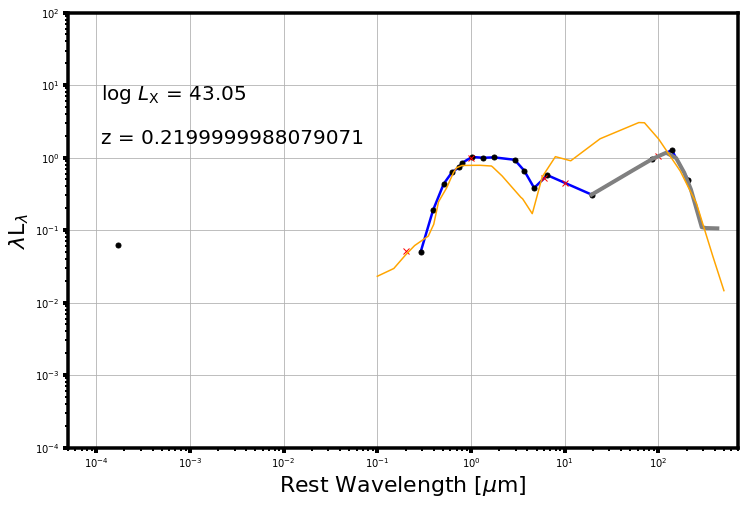

In [9]:
for i in range(len(chandra_cosmos_phot_id_match)):
# for i in range(10):
    if chandra_cosmos_phot_id_match[i] == 205032:
        source = AGN(chandra_cosmos_phot_id_match[i], chandra_cosmos_z_match[i], COSMOS_filters, cosmos_flux_array[i], cosmos_flux_err_array[i])
        source.MakeSED(data_replace_filt=['FLUX_24'])
        source.FIR_extrap(['FLUX_24', 'FLUX_100', 'FLUX_160', 'FLUX_250', 'FLUX_350', 'FLUX_500'])

        cosmos_flux_dict = source.MakeDict(COSMOS_filters,cosmos_flux_array[i])
        cosmos_flux_err_dict = source.MakeDict(COSMOS_filters,cosmos_flux_err_array[i])
        
        Lcheck = source.Lum_filter('FLUX_24')
        F24_out.append(Lcheck)
        stack_bin.append(7)

        ix, iy = source.Int_SED(xmin=1E-1, xmax=1E1)
        int_x.append(ix)
        int_y.append(iy)

        # wfir, ffir, f100, f100_boot = source.Int_SED_FIR(Find_value=100.0,discreet=True,boot=True)
        wfir, ffir, f100 = source.Int_SED_FIR(Find_value=100.0,discreet=True)
        wfir_out.append(wfir)
        ffir_out.append(ffir)

        L100_ratio = source.flux_ratio_lower()
        F100_ratio.append(L100_ratio)

        # f1, f1_boot = source.Find_value(1.0, boot=True)
        # f2, f2_boot = source.Find_value(2.0, boot=True)
        # xval, xval_boot = source.Find_value(3E-4, boot=True)
        # f6, f6_boot = source.Find_value(6.0, boot=True)
        # f025, f025_boot = source.Find_value(0.25, boot=True)
        # f10, f10_boot = source.Find_value(10, boot=True)
        # f2kev, f2kev_boot = source.Find_value(6.1992e-4, boot=True)

        # f015, f015_boot = source.Find_value(0.15, boot=True)
        # f65, f65_boot = source.Find_value(6.5, boot=True)

        f1 = source.Find_value(1.0)
        f2 = source.Find_value(2.0)
        xval = source.Find_value(3E-4)
        f6 = source.Find_value(6.0)
        f025 = source.Find_value(0.25)
        f10 = source.Find_value(10)
        f2kev = source.Find_value(6.1992e-4)

        f015 = source.Find_value(0.2)
        f65 = source.Find_value(6.5)

        # lbol = source.Find_Lbol()
        # lbol_sub = source.Find_Lbol(sub=True, Lscale=scale_array, Lnorm=f1, temp_x=temp_wave, temp_y=temp_lum)
        # lbol_sf_sub = source.Find_Lbol(sub=True,Lscale=scale_array,Lnorm=f1,temp_x=m82_wave,temp_y=m82_lum)

        lbol = source.Find_Lbol()
        lbol_sub = source.Find_Lbol(sub=True,Lscale=scale_array, Lnorm=f1, temp_x=temp_wave, temp_y=temp_lum)
        lbol_sf_sub = source.Find_Lbol(sub=True,Lscale=scale_array, Lnorm=f1, temp_x=m82_wave, temp_y=m82_lum)
        # lbol_sub = source.Find_Lbol_temp_sub(scale_array, f1, temp_wave, temp_lum)
        # lbol_sub, txe, tye, xsube, ysube = source.Find_Lbol_temp_sub(scale_array, f1, temp_wave, temp_lum,sed=True)
        # lbol_sf_sub = source.Find_Lbol_temp_sub(scale_array, f1, m82_wave, m82_lum)
        # lbol_sf_sub, tx, ty, xsub, ysub = source.Find_Lbol_temp_sub(scale_array, f1, m82_wave, m82_lum,sed=True)
        print(np.log10(lbol),np.log10(lbol_sub),np.log10(lbol_sf_sub))
        # lbol_sub = source.Find_Lbol_temp_sub(scale_array, f1, temp_wave, temp_lum, xmax=50)
        shape = source.SED_shape()

        Id, redshift, w, f, frac_err, up_check = source.pull_plot_info(norm_w=1)
        out_ID.append(Id)
        out_x.append(w)
        out_y.append(f)
        out_frac_error.append(frac_err)
        out_Lx.append(chandra_cosmos_Lx_full_match[i])
        out_Lx_hard.append(chandra_cosmos_Lx_hard_match[i])
        out_Lx_soft.append(chandra_cosmos_Lx_soft_match[i])
        out_z.append(chandra_cosmos_z_match[i])
        FIR_upper_lims.append(up_check)

        hao_x, hao_y = source.mix_loc([1,0.3],[3,1])
        # hao_x, hao_y = source.mix_loc([0.3, 1.0], [1.0, 3.0])
        mix_x.append(hao_x)
        mix_y.append(hao_y)

        norm.append(f1)
        F025.append(f025)
        F1.append(f1)
        F2.append(f2)
        F6.append(f6)
        F10.append(f10)
        F100.append(f100)
        F2kev.append(f2kev)
        xval_out.append(xval)
        # F1_boot.append(f1_boot)
        # F025_boot.append(f025_boot)
        # F2_boot.append(f2_boot)
        # F6_boot.append(f6_boot)
        # F10_boot.append(f10_boot)
        # xval_out_boot.append(xval_boot)
        # F100_boot.append(f100_boot)
        # F2kev_boot.append(f2kev_boot)
        Lbol_out.append(lbol)
        Lbol_sub_out.append(lbol_sub)
        Lbol_sf_sub_out.append(lbol_sf_sub)
        Nh.append(chandra_cosmos_Nh_match[i])
        Nh_check.append(cosmos_Nh_check[i])
        abs_check.append(check_abs_match[i])

        shape = source.SED_shape()
        # shape = source.SED_shape(uv1, uv2, mir11, mir12, mir21, mir22)

        uv_slope.append(source.Find_slope(uv1, uv2))
        mir_slope1.append(source.Find_slope(mir11, mir12))
        mir_slope2.append(source.Find_slope(mir21, mir22))
        out_SED_shape.append(shape)
        UV_lum_out.append(source.find_Lum_range(0.1,0.35))
        OPT_lum_out.append(source.find_Lum_range(0.35,3))
        MIR_lum_out.append(source.find_Lum_range(3,30))
        FIR_lum_out.append(source.find_Lum_range(30,500/(1+chandra_cosmos_z_match[i])))
        X_UV_lum_out.append(source.find_Lum_range(1E-3,0.1))
        FIR_R_lum.append(source.find_Lum_range(40,400))

        # print(np.log10(X_UV_lum_out[i]),np.log10(UV_lum_out[i]),np.log10(OPT_lum_out[i]),np.log10(MIR_lum_out[i]),np.log10(FIR_lum_out[i]))
        # print(np.log10(X_UV_lum_out[i]+UV_lum_out[i]+OPT_lum_out[i]+MIR_lum_out[i]+FIR_lum_out[i]))

        plot = Plotter(Id, redshift, w, f, chandra_cosmos_Lx_full_match[i],f1,up_check)

        check = source.check_SED(10, check_span=2.75)
        check6 = source.check_SED(6, check_span=2.75)
        check_sed.append(check)
        check_sed6.append(check6)
        field.append('COSMOS')
        spec_class.append(chandra_cosmos_spec_type_match[i])

        if check6 == 'GOOD':
        # # # #     print(shape, source.Find_slope(uv1,uv2), source.Find_slope(mir11, mir12), source.Find_slope(mir21, mir22))
        #     if shape == 3:
        # print(Id,check6,shape,up_check,source.Find_slope(uv1, uv2),source.Find_slope(mir11, mir12),mir_slope2[i])
            plot.PlotSED(point_x=[0.2,1.0,6.,10,100],point_y=[f015/f1,f1/f1,f6/f1,f10/f1,f100/f1],fir_x = wfir, fir_y = ffir,temp_x=m82_wave,temp_y=m82_lum)#, xsub=xsub, ysub=ysub)




In [8]:
def find_Lum_range(x,y,xmin, xmax):
    # x = np.log10(self.rest_w_cgs[~np.isnan(self.lambdaL_lambda)])
    # # y = np.log10(self.lambdaL_lambda[~np.isnan(self.lambdaL_lambda)])
    # y = np.log10(self.nuL_nu[~np.isnan(self.nuL_nu)])

    Lbol_interp = interpolate.interp1d(x,y,kind='linear',fill_value='extrapolate')

    x_interp = np.linspace(np.log10(xmin*1E-4), np.log10(xmax*1E-4))
    y_interp = 10**Lbol_interp(x_interp)

    x_interp, y_interp = x_interp[::-1], y_interp[::-1]
    freq = 3E10/10**x_interp
    y_interp = y_interp/freq
    L_region = integrate.trapz(y_interp, freq)

    return L_region

def Find_Lbol(x,y,xin=None, yin=None, xmax=None):
        # if xin is None:
        #     x = self.rest_w_microns*1E-4
        #     y = self.nuL_nu
        # else:
        #     x = xin*1E-4
        #     y = yin

        # x = np.append(x, self.FIR_wave*1E-4)
        # y = np.append(y, self.FIR_lambdaL_lambda)
        sort = x.argsort()
        x, y = x[sort], y[sort]

        if xmax != None:
            y = y[x < xmax*1E-4]
            x = x[x < xmax*1E-4]

        x = np.log10(x[~np.isnan(y)])
        y = np.log10(y[~np.isnan(y)])

        Lbol_interp = interpolate.interp1d(
            x, y, kind='linear', fill_value='extrapolate')

        x_interp = np.linspace(min(x), max(x))
        y_interp = 10**Lbol_interp(x_interp)

        # plt.figure(figsize=(8,8))
        # plt.title(self.ID)
        # plt.plot(10**x_interp*1E4,y_interp)
        # plt.xscale('log')
        # plt.yscale('log')
        # plt.show()

        x_interp, y_interp = x_interp[::-1], y_interp[::-1]

        freq = 3E10/10**x_interp
        y_interp = y_interp/freq

        Lbol = integrate.trapz(y_interp, freq)
        # print(self.Lbol)

        return Lbol

def Find_Lbol_temp_sub(x, y, z, scale_L, Lnorm, temp_x, temp_y, xmax=None, sed=False):
        try:
            Lone_temp = temp_y[temp_x == 1.0050][0]
        except IndexError:
            Lone_temp = temp_y[np.round(temp_x, 5) == 1.0][0]
        if z <= 0.6:
            if Lnorm < scale_L[0]:
                scale = Lnorm/Lone_temp
            else:
                scale = scale_L[0]/Lone_temp
        elif (z > 0.6) & (z < 0.9):
            if Lnorm < scale_L[1]:
                scale = Lnorm/Lone_temp
            else:
                scale = scale_L[1]/Lone_temp
        else:
            if Lnorm < scale_L[2]:
                scale = Lnorm/Lone_temp
            else:
                scale = scale_L[2]/Lone_temp
        scale_y = temp_y*scale

        temp_interp = interpolate.interp1d(np.log10(temp_x), np.log10(
            scale_y), kind='linear', fill_value='extrapolate')
        y_interp = 10**temp_interp(np.log10(x))

        y_sub = y - y_interp
        if sed:
            return Find_Lbol(xin=x[y_sub > 0], yin=y_sub[y_sub > 0]), temp_x, scale_y, x, y_sub
        # if xmax is None:
            # return self.Find_Lbol(xin=self.rest_w_microns[y_sub > 0], yin=y_sub[y_sub > 0])
        else:
            return Find_Lbol(xin=x[y_sub > 0], yin=y_sub[y_sub > 0], xmax=xmax)


In [48]:

for i in a:
    print("%.3g" % i)

# A = "{:.5g}".format(a[0])
# print(A)

2.11e-08
2.24
3.45
4.34
5.13


In [81]:
from astropy.table import Table
from astropy.io import ascii
import pandas as pd
A = np.array([21.1232342352324E-9,2.235433113423,3.453,4.34,5.1343212345436543453324])
C = A.copy()
C *=500
H = np.array(['a', 'b', 'c', 'd', 'e'])



fdata = A
fcols = H
data_in = C
tin = Table(data=fdata, names=fcols)
for i in fcols:
    tin[i].format = '{0:.5e}'
tin.add_row(data_in)
print(tin)

tin.write('/Users/connor_auge/Desktop/test.csv', format='ascii.csv',overwrite=True)


# inf = fits.open('/Users/connor_auge/Desktop/test.csv')
# data = inf[1].data
# print('Data:')
# print(data)
inf = ascii.read('/Users/connor_auge/Desktop/test.csv')
print('here')
print(inf)
print(inf.columns)
# tin2 = Table(data=inf)
# print(tin2)

df = pd.read_csv('/Users/connor_auge/Desktop/test.csv')
print('here2:')
print(df)
print(df.columns)
print(df.values)

print('check:')
t = Table(data=df.values,names=df.columns)
t.add_row(A)
print(t)

     a           b           c           d           e     
----------- ----------- ----------- ----------- -----------
2.11232e-08 2.23543e+00 3.45300e+00 4.34000e+00 5.13432e+00
1.05616e-05 1.11772e+03 1.72650e+03 2.17000e+03 2.56716e+03
here
     a         b      c      d       e   
----------- ------- ------ ------ -------
2.11232e-08 2.23543  3.453   4.34 5.13432
1.05616e-05 1117.72 1726.5 2170.0 2567.16
<TableColumns names=('a','b','c','d','e')>
here2:
              a           b         c        d           e
0  2.112320e-08     2.23543     3.453     4.34     5.13432
1  1.056160e-05  1117.72000  1726.500  2170.00  2567.16000
Index(['a', 'b', 'c', 'd', 'e'], dtype='object')
[[2.11232e-08 2.23543e+00 3.45300e+00 4.34000e+00 5.13432e+00]
 [1.05616e-05 1.11772e+03 1.72650e+03 2.17000e+03 2.56716e+03]]
check:
         a                 b          c      d            e        
-------------------- -------------- ------ ------ -----------------
         2.11232e-08        2.23543  3.45